#### Imports 

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

#### Importing Data

In [69]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [70]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [71]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [72]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [73]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


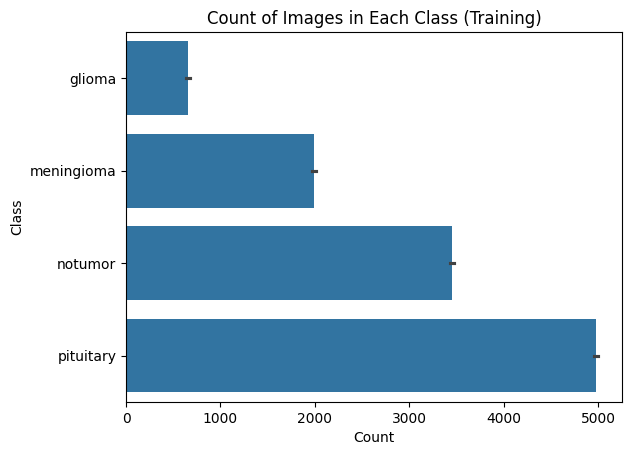

In [74]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

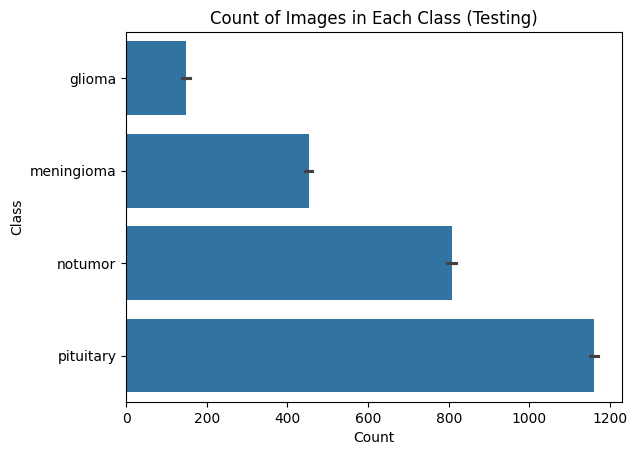

In [75]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

#### Data Preprocessing

In [76]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=True)

# set shuffle equal to True simply for the picture

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [77]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

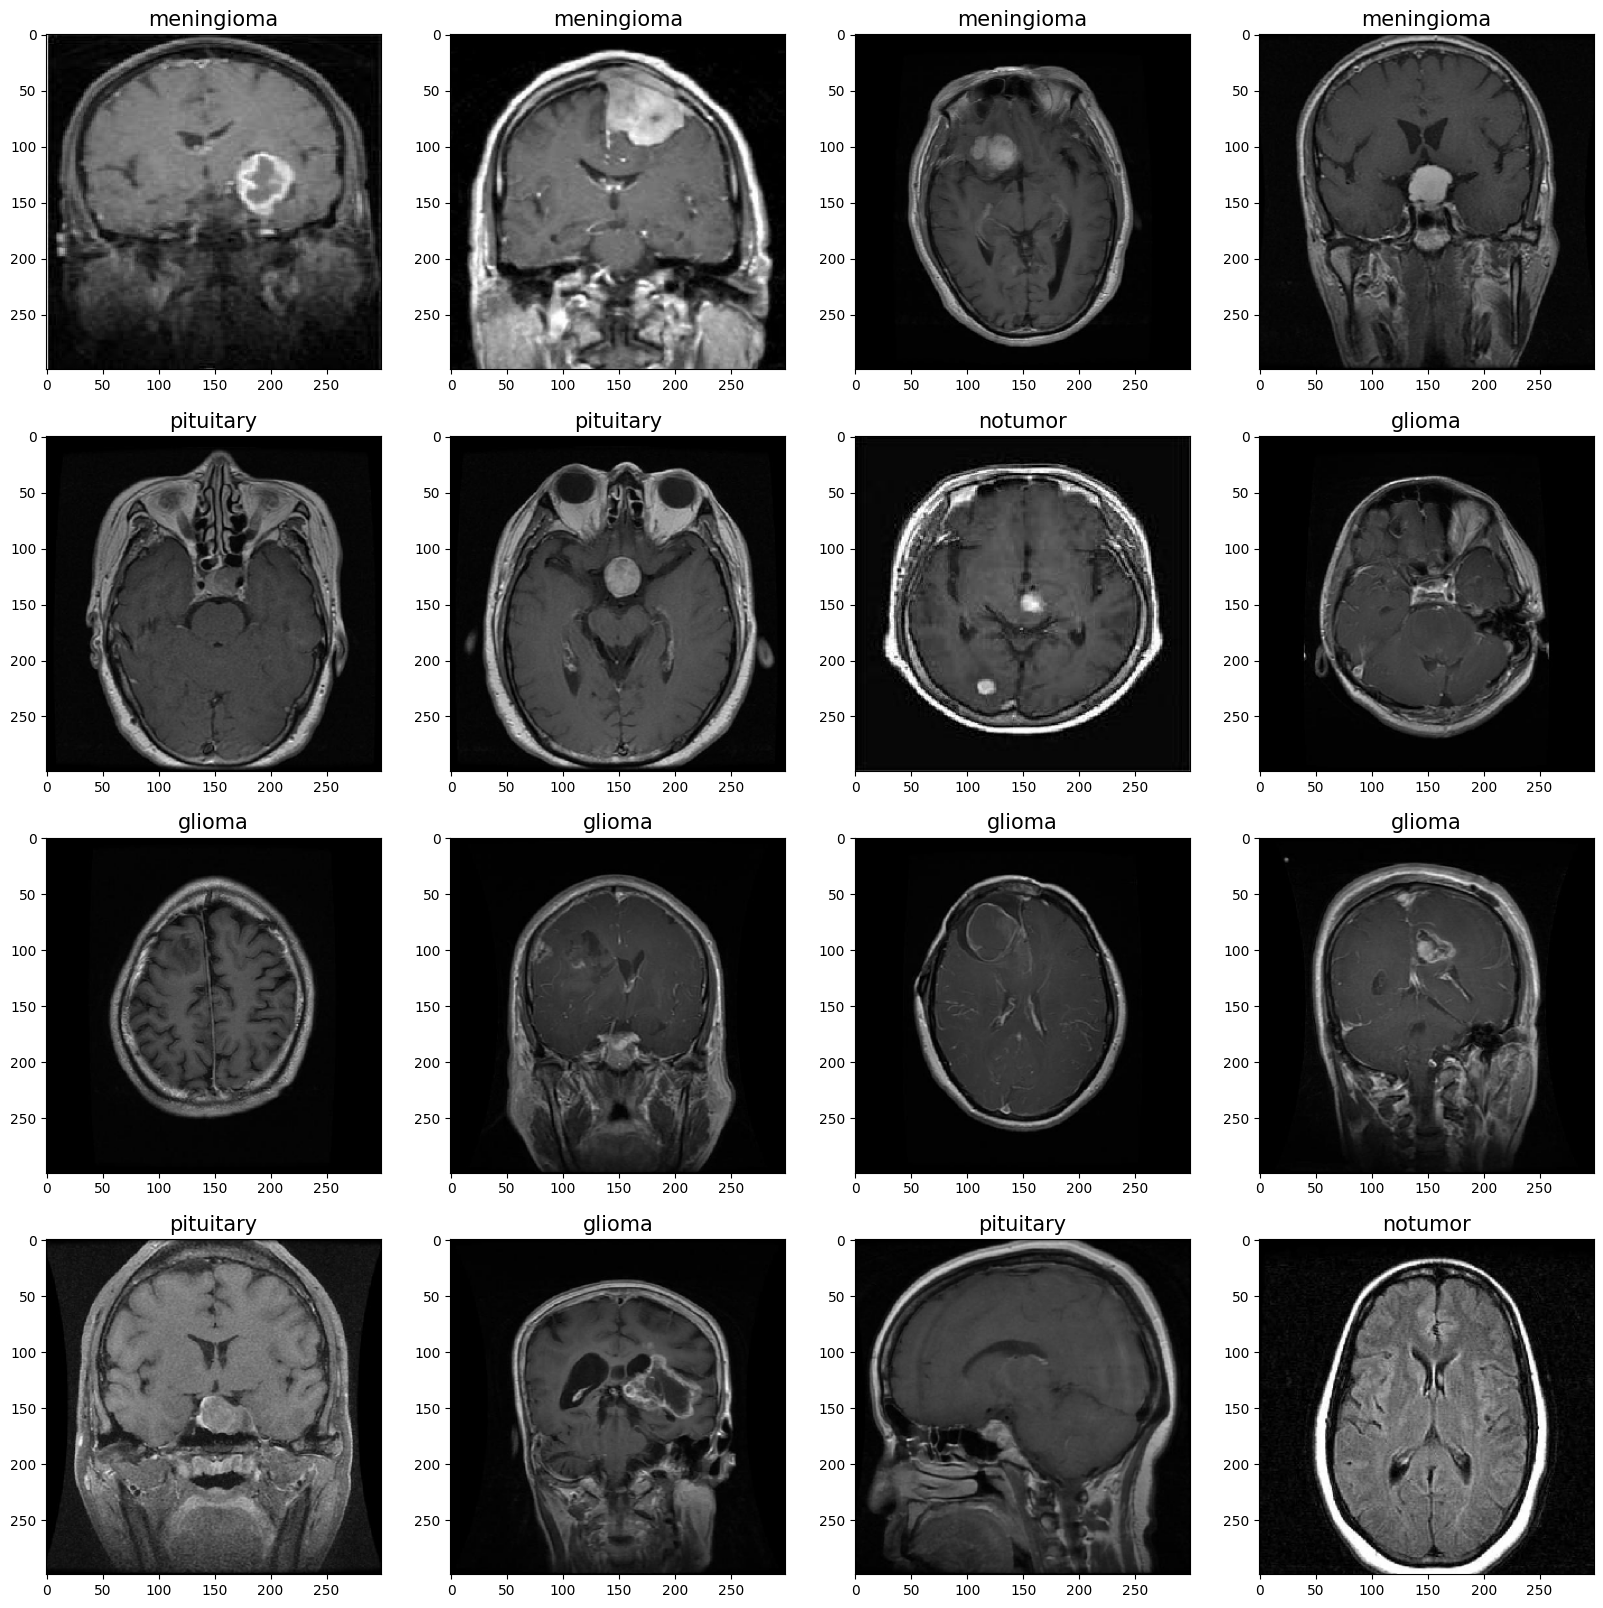

In [78]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

In [79]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size,
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

# set shuffle back to false for model and confusion matrix 
# if set to true, then messes up confusion matrix as true labels 
# are also shuffled with the images. 

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [80]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

#### Initial CNN

In [81]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 235ms/step - accuracy: 0.7491 - loss: 1.6831
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.9354 - loss: 0.2037
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.9821 - loss: 0.0744
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.9947 - loss: 0.0307
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.9995 - loss: 0.0094
82/82 - 5s - 59ms/step - accuracy: 0.9504 - loss: 0.1928
Loss: 0.19275009632110596
Accuracy: 0.950419545173645


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step


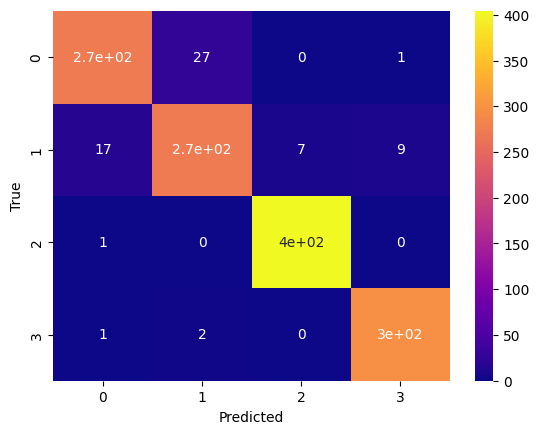

              precision    recall  f1-score   support

      glioma       0.93      0.91      0.92       300
  meningioma       0.90      0.89      0.90       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [82]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Hyperparameter Tuning

In [83]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 606ms/step - accuracy: 0.7397 - loss: 1.5732
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 612ms/step - accuracy: 0.9373 - loss: 0.1828
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 618ms/step - accuracy: 0.9785 - loss: 0.0664
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 606ms/step - accuracy: 0.9932 - loss: 0.0265
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 113s 629ms/step - accuracy: 0.9953 - loss: 0.0157
82/82 - 14s - 168ms/step - accuracy: 0.9443 - loss: 0.1974
Loss: 0.19738760590553284
Accuracy: 0.9443173408508301


82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step


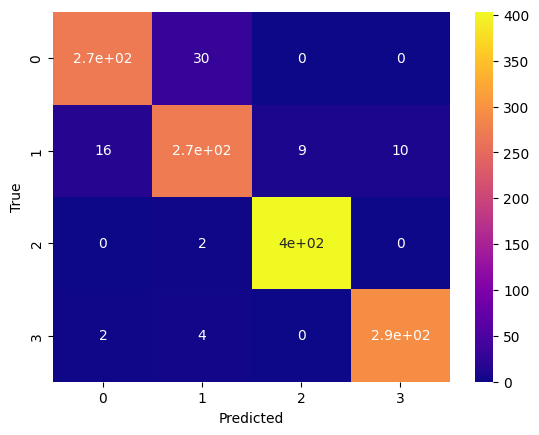

              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       300
  meningioma       0.88      0.89      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.97      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [84]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Anomaly Detection Using Isolation Forests 

In [85]:
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=-2).output 
    # index=-2 gives Dense(64) layer
)

# building feature extractor from trained CNN

"""
input is the original cnn
output is the second to last layer of the CNN
"""

'\ninput is the original cnn\noutput is the second to last layer of the CNN\n'

In [86]:
# Extract features from all Normal training images

normal_class_index = tr_gen.class_indices["notumor"] # this is now the anomaly
# a dictionary mapping the calss names 

normal_features = []
tumor_features = []

for x, y in tr_gen:

    labels = np.argmax(y, axis=1)

    tumor_indices = np.where(labels != normal_class_index)[0]
    # converts one-hot labels into integer class labels
    # returns indices in the batch coreesponding to notumor class

    print(tumor_indices)
    if len(tumor_indices) == 0:
        continue
    # skip batches that don't have normal images

    imgs = x[tumor_indices]
    # only keep images that belong to the notumor class
    feats = feature_extractor.predict(imgs)
    # pass the images through dense(64) feature extractor
    tumor_features.append(feats)

    if len(tumor_features) * tr_gen.batch_size >= tr_gen.n:
        break
    # stop after processed roughly all samples 

tumor_features = np.vstack(tumor_features)
# concentrate all batches vertically --> one big array 
print("Feature Shape:", tumor_features.shape)

[ 0  2  3  4  7  8  9 10 11 12 13 14 15 16 17 19 20 23 25 26 27 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 17 18 19 21 22 23 24 25 26
 27 28 29 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
[ 0  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 21 23 25 27 28 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
[ 0  1  3  4  5  6  7  8  9 11 14 15 17 18 19 20 21 22 23 24 26 27 28 29
 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
[ 0  1  3  4  6  8  9 10 12 13 14 17 18 19 21 22 23 24 25 26 27 28 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
[ 1  2  4  6  8  9 10 11 12 15 16 17 18 19 22 23 24 28 29 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
[ 1  2  3  4  5  6  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27
 28 29 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
[ 1  2  5  6  7  8  9 11 14 15 16 17 18 19 20 21 22 23 24 25 26 28 29 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
[ 0  2  3  4  8 10 11 12 14 15 17 18 20 21 22 23 24 26 27 31]
1/1 ━━━━━━━━━━━━━━━━━━

In [87]:
scaler = StandardScaler()
tumor_features_scaled = scaler.fit_transform(tumor_features)

In [88]:
iso = IsolationForest(
    contamination = 0.02, # percentage of anomalies in notumor, noise
    random_state=42
)

iso.fit(tumor_features_scaled)

train_scores = -iso.decision_function(tumor_features_scaled)

print("Training scores shape:", train_scores.shape)
print("Score Range:", train_scores.min(), "->", train_scores.max())

Training scores shape: (4117,)
Score Range: -0.18153254099080196 -> 0.17302550999963073


In [89]:
def anomaly_score(img):

    feat = feature_extractor.predict(img[None,...])
    # adds a batch dimension --> (1,64) feature vector
    feat_scaled = scaler.transform(feat)
    # scales the vector
    
    score = -iso.decision_function(feat_scaled)[0] # higher = more anomalous
    label = iso.predict(feat_scaled)[0]            # -1 = anomaly, 1 = normal
    return score, label

In [90]:
test_scores = []
test_true = []

ts_gen.reset()

for batch_images, batch_labels in ts_gen:
    batch_true_labels = np.argmax(batch_labels, axis=1)

    for image, true_label in zip(batch_images, batch_true_labels):
        feat = feature_extractor.predict(image[None,...])
        feat_scaled = scaler.transform(feat)
        score = -iso.decision_function(feat_scaled)[0]

        test_scores.append(score)
        test_true.append(1 if true_label == normal_class_index else 0)

    if ts_gen.batch_index == 0:
        break

test_scores = np.array(test_scores)
test_true = np.array(test_true)

threshold = np.percentile(train_scores, 85)
print("Threshold:", threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━

In [91]:
y_pred = (test_scores >= threshold).astype(int)   # 1 = anomaly (notumor)
y_true = test_true

In [92]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8688
Precision: 0.7019
Recall: 1.0000
F1 Score: 0.8248


In [93]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))

[[734 172]
 [  0 405]]
              precision    recall  f1-score   support

           0     1.0000    0.8102    0.8951       906
           1     0.7019    1.0000    0.8248       405

    accuracy                         0.8688      1311
   macro avg     0.8510    0.9051    0.8600      1311
weighted avg     0.9079    0.8688    0.8734      1311



#### Visualize Anomaly

In [94]:
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=-2).output 
    # index=-2 gives Dense(64) layer
)

In [95]:
# Patch Scoring

def extract_patch_features(image, patch_size=64, stride=32):
    H, W, _ = image.shape
    patches = []
    coords = []

    for y in range(0, H - patch_size, stride):
        for x in range(0, W - patch_size, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            coords.append((x,y))

    patches = np.array(patches)
    return patches, coords

In [96]:
# Compute anomaly scores for each patch

def score_patches(patches, iso, feature_extractor):
    patches = patches.astype("float32")

    resized = tf.image.resize(patches, (299,299))

    feats = feature_extractor.predict(resized, verbose=0)
    feats = feats.reshape(len(resized), -1)

    scores = -iso.score_samples(feats)
    return scores

In [97]:
# Build a Heatmap

def build_heatmap(scores, coords, image, patch_size=64, stride=32):
    heatmap = np.zeros((image.shape[0], image.shape[1]))

    for (x,y), score in zip(coords, scores):
        heatmap[y:y+patch_size, x:x+patch_size] = score

    heatmap /= heatmap.max() + 1e-8
    return heatmap

In [98]:
# Bounding Box from heatmap

def heatmap_to_box(heatmap, thresh=0.5):
    mask = heatmap > thresh
    ys, xs = np.where(mask)
    if len(xs) == 0:
        return None
    return xs.min(), ys.min(), xs.max() - xs.min(), ys.max() - ys.min()

In [99]:
import matplotlib.patches as patches

# Visualization

def visualize_iso(image, heatmap, box=None):
    fig, ax = plt.subplots(1, 2 , figsize=(12,6))
    ax[0].imshow(image)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(image, alpha=0.4)
    ax[1].imshow(heatmap, cmap="jet", alpha=0.5)
    ax[1].set_title("Isolation Forest Anomaly Heatmap")
    ax[1].axis("off")

    if box:
        (x, y, w, h) = box
        rect = patches.Rectangle((x, y), w, h,
                                 edgecolor='lime',
                                 facecolor='none',
                                 linewidth=2)
        ax[1].add_patch(rect)

    plt.show()

In [100]:
def iso_visualize(model, iso, image):
    patches, coords = extract_patch_features(image)
    scores = score_patches(patches, iso, feature_extractor)
    heatmap = build_heatmap(scores, coords, image)

    box = heatmap_to_box(heatmap)
    visualize_iso(image, heatmap, box)

    return heatmap, box

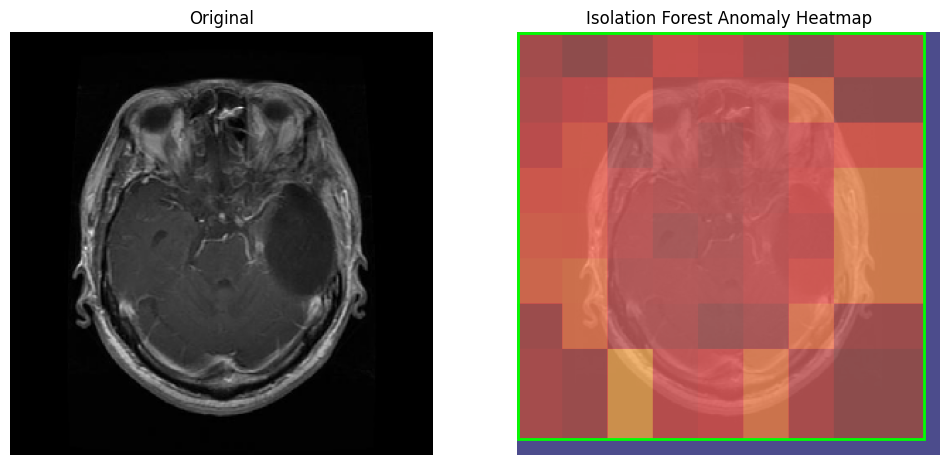

(array([[0.95708886, 0.95708886, 0.95708886, ..., 0.        , 0.        ,
         0.        ],
        [0.95708886, 0.95708886, 0.95708886, ..., 0.        , 0.        ,
         0.        ],
        [0.95708886, 0.95708886, 0.95708886, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 (np.int64(0), np.int64(0), np.int64(287), np.int64(287)))

In [101]:
# How to use

img = images[15]   # from your ts_gen batch
iso_visualize(model, iso, img)

#### Anonaly Detection, autoencoders. 

In [102]:
# laten_dim = 64

# encoder = models.Sequential([
#     layers.Conv2D(64, (3,3), activation="relu", input_shape=(299,299,3)),
#     layers.Conv2D(32, (3,3), activation="relu"),
#     layers.Conv2D(16, (3,3), activation="relu"),
#     layers.Flatten(),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(32, activation="relu"),
#     layers.Dense(laten_dim*2)
# ], name="encoder")

In [103]:
# class Sampling(layers.Layer):
#     def call(self, z_params):
        
#         z_mean, z_log_var = tf.split(z_params, 2, axis=1)
#         # The endoder outputs (z_mean, z_log_var) stacked together,
#         # this line splits them into two tensors

#         eps = tf.random.normal(shape=tf.shape(z_mean))
#         # Generate random noise with the same shape as z_mean
        
#         return z_mean + tf.exp(0.5 * z_log_var) * eps
#         # This is the reparameterization trick:
#         #  - tf.exp = standard deviation
#         #  - muttiply by noise to introduce randomness
#         #  - add mean to shift the distribution
    
"""
Reparameterization trick is required to make the VAE trainable. 

It takes the encoder's output [z_mean, z_log_var], and uses them 
 to produce a vector to be fed into the decoder 

This needs to be done becasue VAE learns distribution, not a single point,
 the model then samples a point from this distribution

Sampling is not differentiable, and since NNs train on gradients, we need
 to rewrite the sampling in a differentiable way (z= mean + std * eps)

"""

"\nReparameterization trick is required to make the VAE trainable. \n\nIt takes the encoder's output [z_mean, z_log_var], and uses them \n to produce a vector to be fed into the decoder \n\nThis needs to be done becasue VAE learns distribution, not a single point,\n the model then samples a point from this distribution\n\nSampling is not differentiable, and since NNs train on gradients, we need\n to rewrite the sampling in a differentiable way (z= mean + std * eps)\n\n"

In [104]:
# decoder = models.Sequential([
#     layers.Dense(294*294*64, activation="relu", input_shape=(laten_dim,)),
#     layers.Reshape((294, 294, 64)),
#     layers.Conv2DTranspose(64, 2, activation="relu"),
#     layers.Conv2DTranspose(32, 2, activation="relu"),
#     layers.Conv2DTranspose(16, 2, activation="relu"),
#     layers.Conv2DTranspose(3, 3, activation="sigmoid"),
# ], name="decoder")

In [105]:
# decoder = models.Sequential([
#     layers.Dense(19*19*64, activation="relu", input_shape=(laten_dim,)),
#     layers.Reshape((19,19,64)),
#     layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2D(3, 3, padding="same", activation="sigmoid"),
#     layers.Cropping2D(((2,3), (2,3))),
# ], name="decoder")

In [106]:
# class VAE(keras.Model):
#     def __init__(self, encoder, decoder):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.sampler = Sampling()

#         self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
#     def train_step(self, data):
        
#         x, _ = data

#         self.beta.assign(tf.minimum(1.0, self.beta + 0.001))

#         with tf.GradientTape() as tape:
#             z_params = self.encoder(x)
#             z_mean, z_log_var = tf.split(z_params, 2, axis=1)

#             z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)

#             z_params_clipped = tf.concat([z_mean, z_log_var], axis=1)

#             z = self.sampler(z_params_clipped)

#             reconstruction = self.decoder(z)

#             recon_loss = tf.reduce_mean(tf.square(x -reconstruction))
#             recon_loss = tf.reduce_sum(recon_loss, axis=list(range(1, len(recon_loss.shape))))
#             recon_loss = tf.reduce_mean(tf.reduce_sum(recon_loss))

#             kl_loss = -0.5 * tf.reduce_mean(
#                 tf.reduce_sum(
#                     1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
#             )

        #     #beta = 0.1

        #     total_loss = recon_loss + self.beta * kl_loss
    
        # grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # return {"loss": total_loss,
        #         "reconstruction_loss": recon_loss,
        #         "kl_loss": kl_loss
        #         }

In [107]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer="adam")
# vae.fit(tr_gen, epochs=1, batch_size=64)
# vae.predict(ts_gen)

The mse loss is alright, but the kl_loss is being collapsed down to zero, nmeaning that it's getting overshadowed by the reconstruction loss, fix that by giving it a weight. Also, change the latent_dim to something bigger, maybe 16 or 32? the 2-dim sapce is too small for the images to actually learn something. 